Streptomycin Exploratory Data Analysis Study: resistance phenotypes, ARGs and population structure. 

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
import dotenv

from sklearn.externals import joblib

# add the 'src' directory as one where we can import modules
project_dir = os.path.join(os.getcwd(), os.pardir)
src_dir = os.path.join(project_dir, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.tools

# load env
%load_ext dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

True

In [3]:
# Load master Xlsx sheet
import pandas as pd
import numpy as np
amrfile = os.path.join(os.environ.get('PRDATA'),'raw','GenotypicAMR_Master.xlsx')
amrdf = pd.read_excel(amrfile)

amrdf = amrdf.replace(r'\s+', np.nan, regex=True)
amrdf = amrdf.replace(r'-', np.nan, regex=True)

In [9]:
# Get strepto resistance data
y = amrdf['phenotypic_streptomycin']
missing = y.isnull()
y = y[~missing].astype(int)

In [10]:
# Gene ARG data
genes = ["aac(3)-IIa|X51534","aac(3)-IId|EU022314",
         "aac(3)-IVa|X01385","aac(3)-Id|AB114632","aac(3)-VIa|M88012",
         "aac(6)-IIc|AF162771","aac(6)-Ib|M21682","aac(6)Ib-cr|DQ303918",
         "aac(6)Ib-cr|EF636461","aacA4|KM278199","aadA12|AY665771","aadA13|AY713504",
         "aadA16|EU675686","aadA1|JQ414041","aadA1|JQ480156","aadA1|JX185132",
         "aadA2|JQ364967","aadA5|AF137361","aadA7|AF224733","ant(2)-Ia|M86913",
         "ant(3)-Ia|X02340","aph(3)-IIa|X57709","aph(3)-Ia|V00359","aph(3)-Ib|AF321551",
         "aph(4)-Ia|V01499","aph(6)-Ic|X01702","aph(6)-Id|M28829","armA|AY220558",
         "strA|M96392"]
genedf = amrdf[genes]
X = genedf.values[~missing,:].astype(int)
genes = genedf.columns.values[np.sum(X,axis=0) != 0]
X = X[:,np.sum(X,axis=0) != 0]

X.shape

(1406, 19)

In [11]:
# Susceptible/Resistant associated with each aminoglycoside ARG
for i in range(X.shape[1]):
    hasgene = X[:,i] == 1
    tot = np.sum(hasgene)
    counts = np.bincount(y[hasgene])
    #print(counts)
    print("Total {} genes found: {} -  S: {} ({}%), R: {} ({}%)".format(genes[i], tot, counts[0], np.round(counts[0]/tot, 3),
                                                                  counts[1], np.round(counts[1]/tot, 3)))

Total aac(3)-IId|EU022314 genes found: 55 -  S: 9 (0.164%), R: 46 (0.836%)
Total aac(3)-IVa|X01385 genes found: 13 -  S: 1 (0.077%), R: 12 (0.923%)
Total aac(3)-VIa|M88012 genes found: 83 -  S: 6 (0.072%), R: 77 (0.928%)
Total aac(6)-Ib|M21682 genes found: 11 -  S: 2 (0.182%), R: 9 (0.818%)
Total aadA13|AY713504 genes found: 1 -  S: 0 (0.0%), R: 1 (1.0%)
Total aadA1|JQ414041 genes found: 7 -  S: 1 (0.143%), R: 6 (0.857%)
Total aadA1|JQ480156 genes found: 2 -  S: 0 (0.0%), R: 2 (1.0%)
Total aadA1|JX185132 genes found: 13 -  S: 4 (0.308%), R: 9 (0.692%)
Total aadA2|JQ364967 genes found: 32 -  S: 8 (0.25%), R: 24 (0.75%)
Total aadA5|AF137361 genes found: 2 -  S: 1 (0.5%), R: 1 (0.5%)
Total ant(2)-Ia|M86913 genes found: 16 -  S: 6 (0.375%), R: 10 (0.625%)
Total ant(3)-Ia|X02340 genes found: 129 -  S: 12 (0.093%), R: 117 (0.907%)
Total aph(3)-IIa|X57709 genes found: 19 -  S: 0 (0.0%), R: 19 (1.0%)
Total aph(3)-Ia|V00359 genes found: 96 -  S: 47 (0.49%), R: 49 (0.51%)
Total aph(3)-Ib|AF32155

229


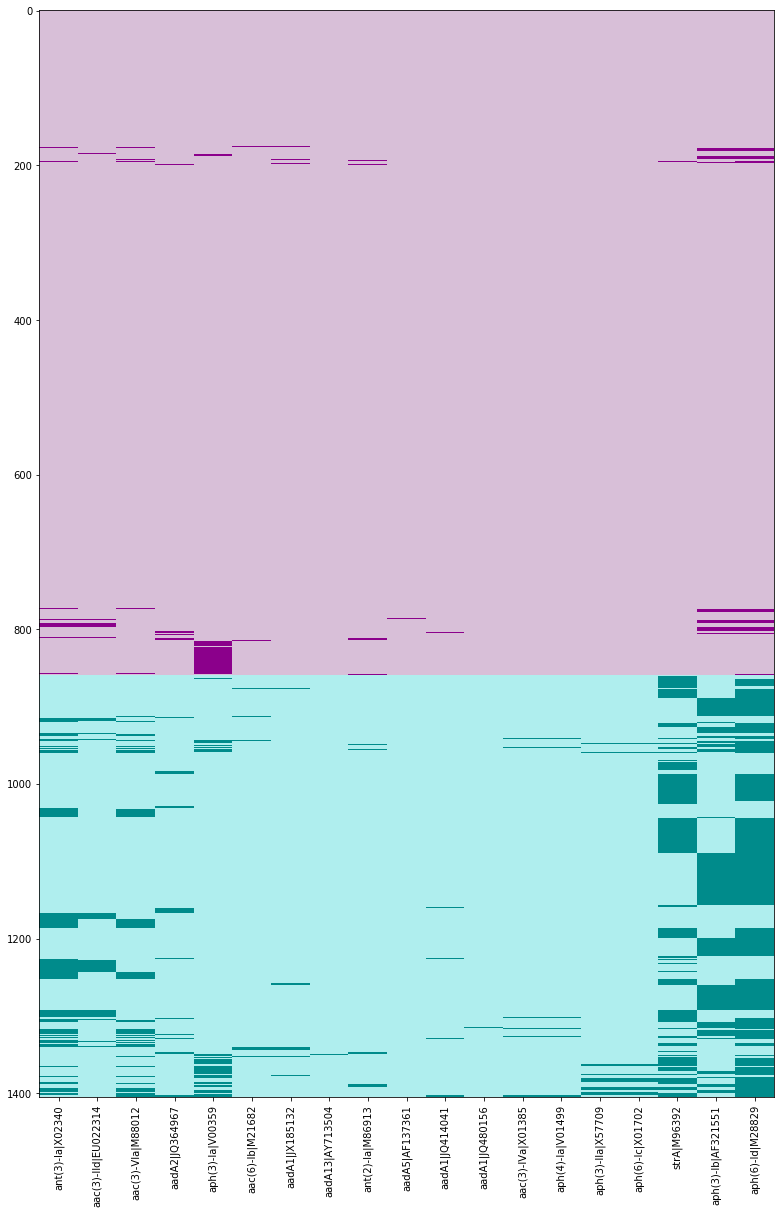

In [14]:
# Distribution of ARGs throughout Resistant vs Susceptible
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import pairwise_distances

gdf = pd.DataFrame(X, index=amrdf['run'][~missing], columns=genes)
print(np.sum(gdf['strA|M96392']))

# Organize matrix for better trend viewing
firstcol = np.where(gdf.sum(axis=0) == gdf.sum(axis=0).max())[0][0] # Pick column with most widely distributed gene

# Compute matrix orderbased on similarity to these
col_jacc = 1 - pairwise_distances(gdf.T, metric = "hamming")
#row_jacc = 1 - pairwise_distances(gdf, metric = "hamming")
#oword = np.argsort(row_jacc[firstrow,:])
colord = np.argsort(col_jacc[firstcol,:])

edf = gdf.copy()
for i in gdf:
    hasgene = (gdf[i] == 1).values
    edf.loc[((y == 1).values & hasgene), i] = 4  # TP
    edf.loc[((y == 0).values & hasgene), i] = 1  # FP
    edf.loc[((y == 1).values & ~hasgene), i] = 3  # FN
    edf.loc[((y == 0).values & ~hasgene), i] = 2  # TN

# Sort matrix using previously computed orders
edf = edf.iloc[:,colord]

# define the colormap
cmap = mpl.colors.ListedColormap(["darkmagenta","thistle","paleturquoise","darkcyan"], name='custom', N=None)

fig, ax = plt.subplots(1,1, figsize=(20,20))

ax.imshow(edf, cmap=cmap, interpolation='none')
ax.set_aspect(0.02)
plt.xticks(range(19), edf.columns.values, rotation='vertical')

plt.show()

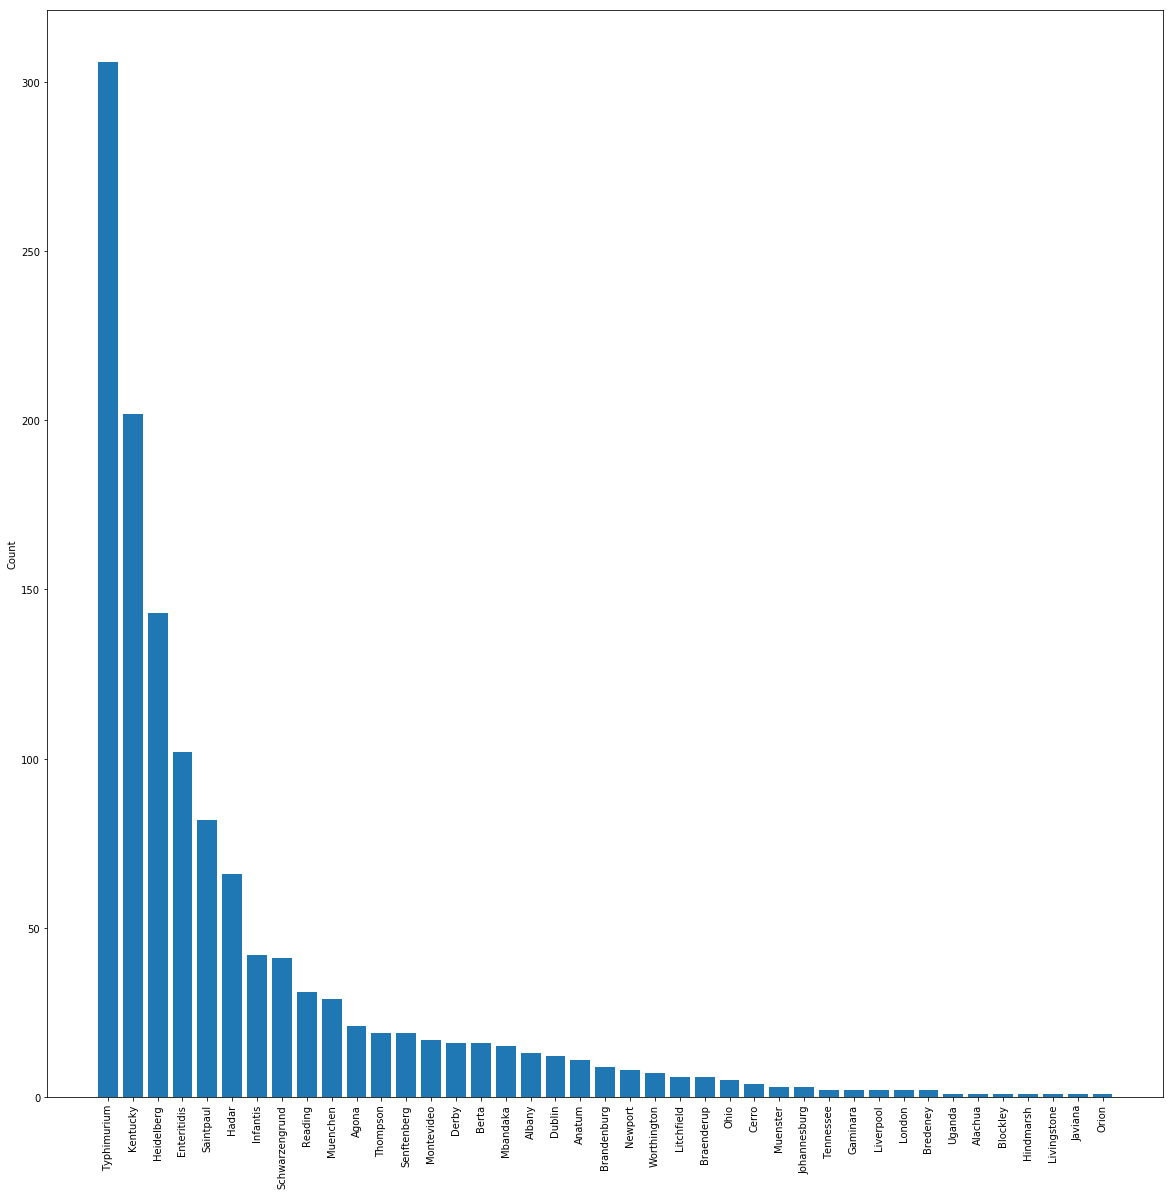

/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


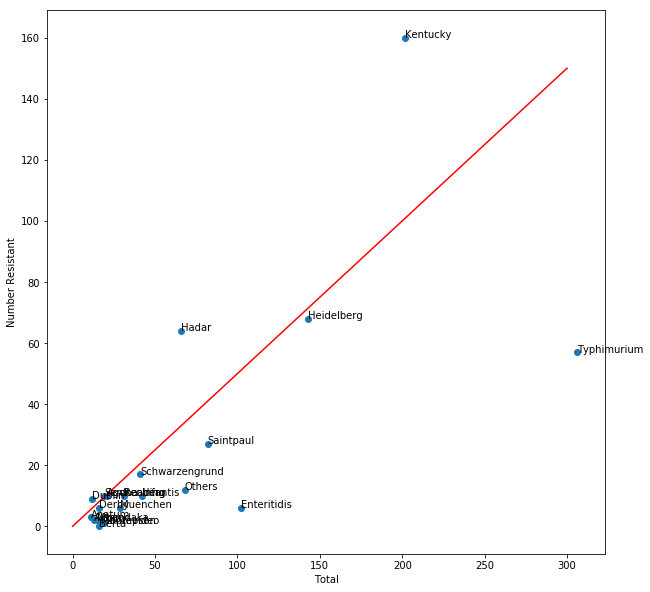

In [111]:
# Plot % resistance in each serovar

# Strepto data
sdf = amrdf[['serovar', 'phenotypic_streptomycin']].dropna()

sdf.serovar = sdf.serovar.str.title()

# Strain distribution
fig, ax = plt.subplots(1,1, figsize=(20,20))
counts = sdf['serovar'].value_counts()
n = len(counts)
ax.bar(range(n), counts)
plt.xticks(range(n), counts.index.values, rotation='vertical')
plt.ylabel('Count')
plt.show()

# Collapse some under-represented strains into 'other'
total = sdf.groupby('serovar').count()
others = total.index[total['phenotypic_streptomycin'] < 10].values
others
sdf.serovar[sdf['serovar'].isin(others)] = 'Others'

# Proportion of strain resistant to strepto
resistant = sdf.groupby('serovar').sum()
total = sdf.groupby('serovar').count()
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(color='red')
plt.plot([0, 300], [0, 150], 'k-', color = 'r')
ax.scatter(total['phenotypic_streptomycin'], resistant['phenotypic_streptomycin'])
for i, txt in enumerate(resistant.index):
    ax.annotate(txt, (total['phenotypic_streptomycin'][i],resistant['phenotypic_streptomycin'][i]))
plt.xlabel('Total')
plt.ylabel('Number Resistant')
plt.show()


/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


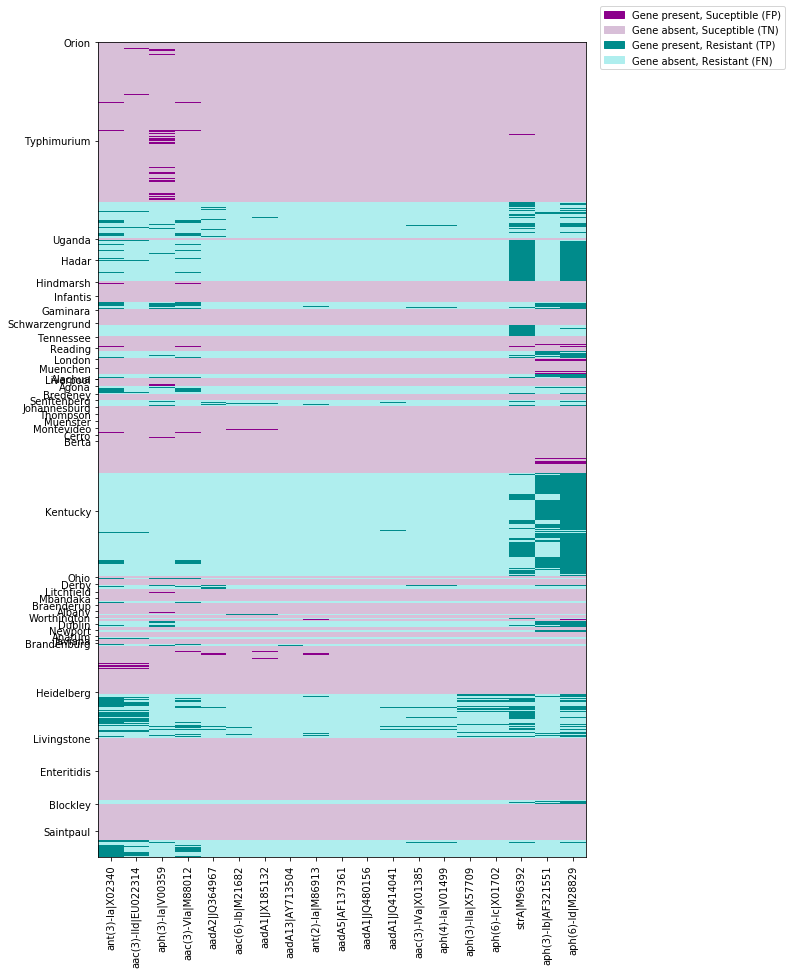

In [112]:
# Distribution of ARGs by serovar
cols = ['serovar','phenotypic_streptomycin'] + list(genes)
streptodf = amrdf[cols].dropna()
streptodf.serovar = streptodf.serovar.str.title()

gdf2 = streptodf[genes]
y = streptodf['phenotypic_streptomycin']

# Organize matrix by serovar & resistant status
# labels = streptodf.serovar.astype(str) +'_'+ y.astype(str)
# roword = np.argsort(labels)
# labels = labels.iloc[roword]
labeldf = streptodf[['serovar','phenotypic_streptomycin']]
labeldf = labeldf.assign(order=np.nan)
sLength = len(labeldf['serovar'])
ascord = labeldf.groupby(['serovar']).size().sort_values()
i = 0
j = len(ascord)-1
k = 0
label_unique = []
while i <= j:
    nextlabel = ascord.index[i]
    labeldf['order'].loc[labeldf.serovar == nextlabel] = k
    label_unique.append(nextlabel)
    k += 1
    if j != i:
        nextlabel = ascord.index[j]
        labeldf['order'].loc[labeldf.serovar == nextlabel] = k
        k += 1
        label_unique.append(nextlabel)
    j -= 1
    i += 1
    
sortinglabels = labeldf.order.astype(str) +'_'+ y.astype(str)
roword = np.argsort(sortinglabels)
labeldf = labeldf.iloc[roword,:]

# Organize columns by similarity of sets
firstcol = np.where(gdf2.sum(axis=0) == gdf2.sum(axis=0).max())[0][0] # Pick column with most widely distributed gene

# Compute matrix orderbased on similarity to these
col_jacc = 1 - pairwise_distances(gdf2.T, metric = "hamming")
colord = np.argsort(col_jacc[firstcol,:])

label_indices.append(ix[0][0])
    
label_indices = []
for l in label_unique:
    ix = np.where(labeldf.serovar == l)
    row = int(len(ix[0])/2)-1
    label_indices.append(ix[0][row])

edf = gdf2.copy()
for i in gdf2:
    hasgene = (gdf2[i] == 1).values
    edf.loc[((y == 1).values & hasgene), i] = 4  # TP
    edf.loc[((y == 0).values & hasgene), i] = 1  # FP
    edf.loc[((y == 1).values & ~hasgene), i] = 3  # FN
    edf.loc[((y == 0).values & ~hasgene), i] = 2  # TN

# Sort matrix using previously computed orders
edf = edf.iloc[:,colord]
edf = edf.iloc[roword, :]

# define the colormap
cmap = mpl.colors.ListedColormap(["darkmagenta","thistle","paleturquoise","darkcyan"], name='custom', N=None)
fig, ax = plt.subplots(1,1, figsize=(15,15))

ax.imshow(edf, cmap=cmap, interpolation='none')
ax.set_aspect(0.025)
plt.xticks(range(19), edf.columns.values, rotation='vertical')
plt.yticks(label_indices, label_unique)

# Legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='darkmagenta', label='Gene present, Suceptible (FP)')
pink_patch = mpatches.Patch(color='thistle', label='Gene absent, Suceptible (TN)')
blue_patch = mpatches.Patch(color='darkcyan', label='Gene present, Resistant (TP)')
aqua_patch = mpatches.Patch(color='paleturquoise', label='Gene absent, Resistant (FN)')
ax.legend(handles=[red_patch, pink_patch, blue_patch, aqua_patch], loc='upper left', bbox_to_anchor=(1.02, 1.05))

plt.show()

In [110]:
edf

,ant(3)-Ia|X02340,aac(3)-IId|EU022314,aph(3)-Ia|V00359,aac(3)-VIa|M88012,aadA2|JQ364967,aac(6)-Ib|M21682,aadA1|JX185132,aadA13|AY713504,ant(2)-Ia|M86913,aadA5|AF137361,aadA1|JQ480156,aadA1|JQ414041,aac(3)-IVa|X01385,aph(4)-Ia|V01499,aph(3)-IIa|X57709,aph(6)-Ic|X01702,strA|M96392,aph(3)-Ib|AF321551,aph(6)-Id|M28829
363,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
175,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
176,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
631,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
630,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
629,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
628,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
627,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
626,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
184,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [5]:
df = amrdf[['serovar']].dropna()
df.serovar = df.serovar.str.title()

In [12]:
len(df.groupby('serovar').count())

57